# Sanjay Avva - Project II
## Date: 12/7/25
### Yelp Analysis Review

### Question: Which of the 3 US Major Cities (NYC, LA, Chicago) has the best hotels?
### Problem: In the 21st century, due to the vast amounts of media, most vacationers often choose their destination from pure critic ratings and other unorganized statistics, but few recognize more than one or two reviews/comments, leading to a chance of biased descision-making when choosing a city to travel to.

### Solution: Delve deeper into the sentimentality of human reviews using the NaiveBayes Analyzer and developing a review word cloud to help understand the true nature of reviews, and how certain types of businesses receive reviews with key words that convey telling information on quality.


## Setup libraries and download nltk modules, Init NaiveBayesAnalyzer

In [ ]:
import requests
import yelpkeys
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
import re

nb_analyzer = NaiveBayesAnalyzer()

## Load API  Keys

In [82]:
APIKEY = yelpkeys.api_key #grab API Key from yelpkeys.py
headers = {'Authorization': 'Bearer %s' % yelpkeys.api_key,}

## Create Review Bucket Function (note: Used Gemini to understand id-sequencing when using the Yelp Fusion Api)

In [83]:
def fetchreviews(city): #function for extracting yelpApi data per city, limit=7
    reviews_list = [] #review data bucket
    url = "https://api.yelp.com/v3/businesses/search"
    #define params, limi = 7, 7 hotels per city, 3 reviews per hotel, 3 cities = 63 reviews total
    params = {"term": "hotels", "location": city, "limit": 7}
    results = requests.get(url, headers=headers, params=params).json() #json dict from api request for business list

    for business in results.get('businesses'): #scan every business given
        biz_id = business['id']
        review_url = f"https://api.yelp.com/v3/businesses/{biz_id}/reviews" #get reviews dict
        review_data = requests.get(review_url, headers=headers).json()

        for r in review_data.get('reviews', []): #organize review data into lists
            reviews_list.append({
                "city": city,
                "business": business['name'],
                "text": r['text']
            })

    return reviews_list

## Run for each city, develop universal bucket for all cities, business reviews.

In [84]:
cities = ["Los Angeles", "Chicago", "New York City"] #location defines

all_reviews = []#hub bucket for all review dicts from all busineses from cities
for c in cities:
    all_reviews.extend(fetchreviews(c)) #add data from gathered review func into hub bucket

len(all_reviews) #check if the reviews is at least 60

63

## Clean Reviews by filtering out unwanted characters/sequences

In [85]:
def clean_review(text): #cleaning func per review
    text = re.sub(r"http\S+", "", text) #no urls
    text = re.sub(r"[^A-Za-z\s]", "", text) #remove chars not in the list of regular characters and spaces
    return text.lower() #lowercase to not bias confuse the sentiment analyzer

## Convert cleaned universal review bucket into dataframe

In [86]:
df = pd.DataFrame(all_reviews) #convert univ bucket to dataframe
df["clean"] = df["text"].apply(clean_review) #clean enire df
df.sample()

,city,business,text,clean
27,Chicago,"The Langham, Chicago",I stayed here while checking out the Chicago J...,i stayed here while checking out the chicago j...


## Add columns for polarity attributes and labels, demonstrate percentages of polarity (from textblob)

In [87]:

def tb_polar(text):
    return TextBlob(text).sentiment.polarity #returns polarity raw val

def senti_lbl(text):
    blob = TextBlob(text) #classifys textblob polarity into labels for donut
    polarity = blob.sentiment.polarity

    if polarity > 0.05:
        return "positive"
    elif polarity < -0.05:
        return "negative"
    else:
        return "neutral"

In [88]:

df["tb_polarity"] = df["clean"].apply(tb_polar) #add new columns with new data
df["tb_label"] = df["clean"].apply(senti_lbl)

df["tb_label"].value_counts(normalize=True)
result = df["tb_label"].value_counts(normalize=True) * 100 #turns into pctges
df.sample()



,city,business,text,clean,tb_polarity,tb_label
56,New York City,The Ludlow New York City,Our room was not properly cleaned--there was h...,our room was not properly cleanedthere was hai...,0.0,neutral


In [89]:
result

,proportion
tb_label,
positive,85.714286
neutral,11.111111
negative,3.174603


## Create Donut Chart of Textblob Sentiment (3 classes)

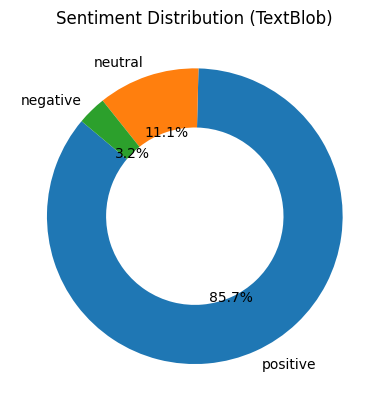

In [90]:
plt.pie(result, labels=result.index, autopct='%1.1f%%',  #make donut
        wedgeprops={'width':0.4},startangle=140)
plt.title("Sentiment Distribution (TextBlob)")
plt.show()

#

## Create NaiveBayes Polarity metrics

In [91]:
def nbclassify(text): #naivebayes analyzer
    blob = TextBlob(text, analyzer=nb_analyzer)
    return blob.sentiment.classification #returns nb_anlazyer (init'd at the start) used nltk movie rev

In [92]:
df["nb_label"] = df["clean"].apply(nbclassify) #stores nb values in another col

df["nb_label"].value_counts(normalize=True)
result2 = df["nb_label"].value_counts(normalize=True) * 100
result2 #pctg form


,proportion
nb_label,
pos,84.126984
neg,15.873016


## Create Donut Chart of NB Sentiment (2 classes)

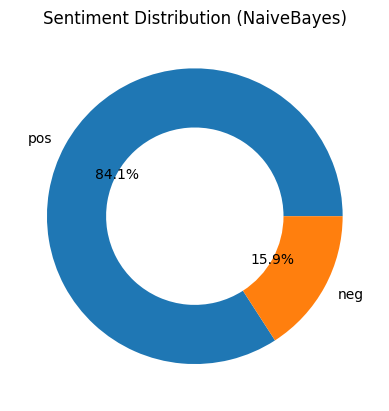

In [93]:
plt.pie( #donut styling
    result2,
    labels=result2.index,
    autopct='%1.1f%%',
    wedgeprops={'width':0.4}
)
plt.title("Sentiment Distribution (NaiveBayes)")
plt.show()

## Answering Question: Breaking down by city sentiment, evaluating pctgs per

In [94]:
nb_city_counts = (
    df.groupby(["city","nb_label"])
      .size()
      .unstack(fill_value=0) #breaks reviews by city and nb label
)

nb_city_pct = nb_city_counts.div(nb_city_counts.sum(axis=1), axis=0) * 100
nb_city_pct #percentage of pos/neg reviews by city

nb_label,neg,pos
city,,
Chicago,23.809524,76.190476
Los Angeles,9.523810,90.476190
New York City,14.285714,85.714286


## Graphing Pos pctgs (Viz)

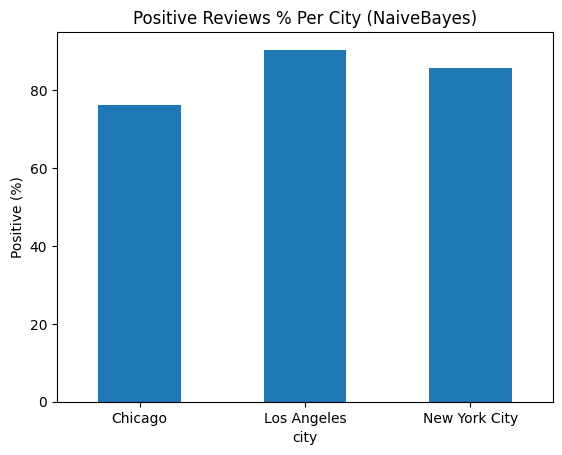

In [95]:
nb_city_pct['pos'].plot( #graphs "city with besdt hotel"
    kind='bar',
    title='Positive Reviews % Per City (NaiveBayes)'
)

plt.ylabel('Positive (%)')
plt.xticks(rotation=0)
plt.show()

## WordCloud Setup (remove stopwords)

In [96]:
stop = set(stopwords.words('english')) #grabs stopwrods

def removestopwrds(text):
    words = text.split()
    filtered = [word for word in words if word not in stop]
    return " ".join(filtered) #function to remove stopwords through list conversion iteration

In [97]:
df["nostop"] = df["clean"].apply(removestopwrds) #apply across df

## Create WordCloud Viz

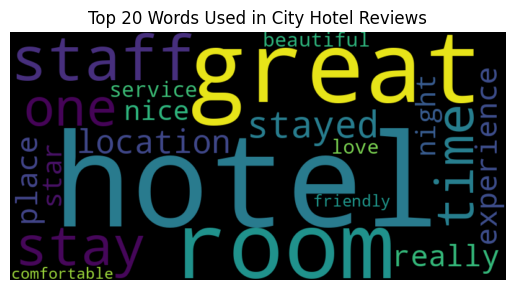

In [98]:
text_all = " ".join(df["nostop"].tolist()) #combines all stopworded text into one for processing

wc = WordCloud(width=800, height=400, max_words=20).generate(text_all) #crete wordcloud

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Top 20 Words Used in City Hotel Reviews")  #display
plt.show()

### Verdict: The City with the best hotels is Los Angeles, with the highest proportion of Positive-Negative Review Sentiments. Chicago, on the other hand, has the opposite: the most negative percentage of reviews of the 3 big cities evaluated.

### Additional: The TextBlob analyzer was more descriptive in its final classification, in comparison with NaiveBayes, which did not include a Neutral Class, seeing as it was strictly definitive in it's classification.

### Verdict WordCloud: Lots of reviews included descriptors on hotel attribs (room, staff, place) and tended to use short gestures of happiness (enjoy, love) to convey their feelings, also indicating that reviewers often were typically comfortable in using casual laungauge to do so.